In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as spss
import seaborn as sns
# 导入相关库


In [2]:

data = pd.read_csv("cbg_patterns.csv")

## 1.对数据集进行处理，转换成适合关联规则挖掘的形式

In [3]:
# 将原数据由字符串形式处理成列表或字典的形式，方便后续处理
Nominal_Attributes = ["visitor_home_cbgs", "visitor_work_cbgs","related_same_day_brand","related_same_month_brand","top_brands"]

dataset = data[Nominal_Attributes].copy()
for attribute in Nominal_Attributes:
    dataset[attribute] = dataset[attribute].apply(lambda x: np.nan if len(x)==2 else json.loads(x))
        
dataset.isna().sum()

visitor_home_cbgs           28412
visitor_work_cbgs           51152
related_same_day_brand      35542
related_same_month_brand     2983
top_brands                  74540
dtype: int64

In [5]:
type(dataset['related_same_day_brand'])

pandas.core.series.Series

In [5]:
dataset['related_same_day_brand'].head()

0    [Chick-fil-A, mcdonalds, Marathon Petroleum, w...
1         [Shell Oil, mcdonalds, Chick-fil-A, Chevron]
2                                     [Dollar General]
3    [Chick-fil-A, Sam's Club, Dollar General, walm...
4                  [Chevron, Daylight Donuts, walmart]
Name: related_same_day_brand, dtype: object

In [6]:
dataset['related_same_day_brand'][0]

['Chick-fil-A', 'mcdonalds', 'Marathon Petroleum', 'walmart']

In [7]:
type(dataset['related_same_day_brand'][0])

list

将"related_same_day_brand"由原始数据集中的string转为了Series存储，并且每一个事务有一个list存储，事务中的项是一个string。

完成了对数据集处理的过程。
## 2.找出频繁项集；
下面使用Apriori算法找出频繁项集
以"related_same_month_brand"为例

In [9]:
dataset["related_same_month_brand"].dropna().count()

217752

Apriori算法的缺点是需要不断扫描数据集，不断地求候选项集的支持度从而判断它是否是频繁项集。当数据集很大的时候，这种算法的效率将会非常低。 


In [165]:
"""
apriori 算法
参考：http://www.cnblogs.com/llhthinker/p/6719779.html
"""

# def load_data_set():
#     """
#     Load a sample data set (From Data Mining: Concepts and Techniques, 3th Edition)
#     Returns: 
#         A data set: A list of transactions. Each transaction contains several items.
#     """
#     data_set = [['l1', 'l2', 'l5'], ['l2', 'l4'], ['l2', 'l3'],
#             ['l1', 'l2', 'l4'], ['l1', 'l3'], ['l2', 'l3'],
#             ['l1', 'l3'], ['l1', 'l2', 'l3', 'l5'], ['l1', 'l2', 'l3']]
#     return data_set

def create_C1(data_set):
    """
    创建候选集C1，事务中每个项都是候选1项集C1的成员。
    扫描所有的事务，获得每个项，生成C1，去重。
    Args:
        data_set: 事务列表， 每个事务都包含一些项。
    Returns:
        C1: 一个集合，包含了所有的候选1项集。
    """
    C1 = set()
    for t in data_set:
        for item in t:
            item_set = frozenset([item])
            C1.add(item_set)
    return C1


def is_apriori(Ck_item, Lksub1):
    """
    剪枝策略（先验性质）：任何非频繁的(k-1)项集都不是k项频繁集的子集。
    即：如果一个候选k项集Ck的(k-1)项子集不在Lk-1中，则该候选也不可能是频繁的，从而可以从Ck中删除。
    Args:
        Ck_item: 候选k项集，包含所有候选k项频繁项集
        Lksub1: Lk-1, k-1项频繁集，包含所有的k-1项频繁项集。
    Returns:
        True: 满足先验性质（保留）
        False: 不满足先验性质（剪枝）
    """
    for item in Ck_item:
        sub_Ck = Ck_item - frozenset([item])
        if sub_Ck not in Lksub1:
            return False
    return True


def create_Ck(Lksub1, k):
    """
    通过(k-1)项频繁集 Lk-1 的自身连接产生候选k项集 Ck，包含了所有候选k项频繁项集。
    连接： 
        Apriori算法假定项集中的项按照字典序排序。
        如果Lk-1中某两个的元素（项集）itemset1和itemset2的前(k-2)个项是相同的，则称itemset1和itemset2是可连接的。
        所以itemset1与itemset2连接产生的结果项集是{itemset1[1], itemset1[2], …, itemset1[k-1], itemset2[k-1]}。
        也就是itemset1加上itemset2的最后项。
    Args:
        Lksub1: Lk-1项频繁项集。
        k: 频繁项集的项数。
    Return:
        Ck: 候选k项集，包含所有候选k项频繁项集
    """
    Ck = set()
    len_Lksub1 = len(Lksub1)
#     print("len_Lksub1:",len_Lksub1," k:",k)
    list_Lksub1 = list(Lksub1) # Lk-1频繁项集
    for i in range(len_Lksub1):
        for j in range(1, len_Lksub1):
            l1 = list(list_Lksub1[i])
            l2 = list(list_Lksub1[j])
            l1.sort() # 按照字典序排序
            l2.sort()
            if l1[0:k-2] == l2[0:k-2]: # 可连接
                Ck_item = list_Lksub1[i] | list_Lksub1[j]
                if is_apriori(Ck_item, Lksub1): # 先验性质 剪枝
                    Ck.add(Ck_item)
    return Ck


def generate_Lk_by_Ck(data_set, Ck, min_support, support_data):
    """
    通过k项候选频繁项集Ck，生成k项频繁项集Lk。
    删除Ck中小于最小支持度的项。
    Args:
        data_set: 事务列表
        Ck: 候选k项集，包含所有的候选k项频繁集。
        min_support: 最小支持度阈值
        support_data: 一个字典，键：频繁项集，值：支持度。
    Returns:
        Lk: k项频繁集，包含所有的k项频繁项集。
    """
    Lk = set()
    item_count = {}
    # 计算Ck中所有候选k项集的支持度计数（频数）
    for t in data_set:
        for item in Ck:
            if item.issubset(t):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1
    t_num = float(len(data_set))
    
    # 计算每个候选k项集的支持度，大于最小支持度阈值的
    for item in item_count:
        if (item_count[item] / t_num) >= min_support:
            Lk.add(item)
            support_data[item] = item_count[item] / t_num
    return Lk

def generate_L(data_set, k, min_support):
    """
    生成k项即k项以下的频繁项集
    步骤1：扫描所有项集，生成C1
    步骤2：根据最小支持度阈值，删减C1,生成L1
    步骤3：根据Lk-1生成Ck
    步骤4：根据最小支持度阈值，删减Ck，生成Lk并记录
    重复步骤3-4
    Args:
        data_set: 事务列表。
        k: 频繁项集最大项数
        min_support: 最小支持度阈值
    Returns:
        L: 频繁项集Lk
        support_data: 一个字典，键：频繁项集，值：支持度。
    """
    support_data = {}
    C1 = create_C1(data_set)
    L1 = generate_Lk_by_Ck(data_set, C1, min_support, support_data)
    Lksub1 = L1.copy()
    L = []
    L.append(Lksub1)
    for i in range(2, k+1):
        Ci = create_Ck(Lksub1, i)
        Li = generate_Lk_by_Ck(data_set, Ci, min_support, support_data)
        Lksub1 = Li.copy()
        L.append(Lksub1)
    return L, support_data



In [330]:
from datetime import datetime
data_set = dataset['related_same_month_brand'].dropna().tolist()

start = datetime.now()
# 找出k项频繁项集
k=3
L, support_data = generate_L(data_set, k, min_support=0.2)
deltatime = datetime.now() - start
get_frequent_time = deltatime.seconds + deltatime.microseconds / 1000000

# print("通过Apriori算法找出 {0}项 频繁项集".format(k))
# print("耗时：{0} s".format(get_frequent_time)  )
# for Lk in L:
#     print("="*50)
#     print("frequent " + str(len(list(Lk)[0])) + "-itemsets\t\tsupport")
#     print("="*50)
#     for freq_set in Lk:
#         print (freq_set, support_data[freq_set])
# print()


In [331]:
print("通过Apriori算法找出 {0}项 频繁项集".format(k))
print("耗时：{0} s".format(get_frequent_time)  )
freq_result = pd.DataFrame(columns= ["itemsets","support"])
for Lk in L:
    count = 1
    for freq_set in Lk:
        
        freq_result = freq_result.append(pd.DataFrame({'itemsets':freq_set,
                                          'support' :support_data[freq_set]},
                                        index = ["{0:02d}-itemsets {1:03d}".format(len(list(Lk)[0]),count)]))
        count +=1
freq_result

通过Apriori算法找出 3项 频繁项集
耗时：82.108295 s


,itemsets,support
01-itemsets 001,(BP),0.210382
01-itemsets 002,(SUBWAY),0.481630
01-itemsets 003,(7-Eleven US),0.204692
01-itemsets 004,(walmart),0.754744
01-itemsets 005,(Target),0.249146
01-itemsets 006,(mcdonalds),0.948042
01-itemsets 007,(Chick-fil-A),0.216071
01-itemsets 008,(Chevron),0.215291
01-itemsets 009,(starbucks),0.411780
01-itemsets 010,(Shell Oil),0.358114


## 3.导出关联规则，计算其支持度和置信度;


In [332]:

def generate_association_rules(L, support_data, min_conf):
    """
    通过频繁项集导出关联规则。
    对每个频繁项集Li，产生其所有的非空子集S 首先是1项频繁集，然后是2项、3项...
    若SUP(Li)/SUP(Li-S)>最小置信度阈值，则有关联规则 Li-S => S
    Args:
        L: 频繁项集Lk
        support_data: 一个字典，键：频繁项集，值：支持度。
        min_conf: 最小置信度阈值
    Returns:
        association_rule_list: 关联规则列表，每个规则包含四个元素，A,B,置信度，支持度
    """
    association_rule_list = []
    sub_set_list = []
    for i in range(0, len(L)):
        for freq_set in L[i]: # L[0] 1项频繁集 ；L[1] 2项频繁集；......
            for sub_set in sub_set_list:
                if sub_set.issubset(freq_set):
                    conf = support_data[freq_set] / support_data[freq_set - sub_set]
                    association_rule = (freq_set - sub_set, sub_set, conf,support_data[freq_set])
                    if conf >= min_conf and association_rule not in association_rule_list:
                        # print(freq_set-sub_set, " => ", sub_set, "conf: ", conf)
                        association_rule_list.append(association_rule)
            sub_set_list.append(freq_set)
    return association_rule_list

In [333]:
# 导出关联规则
start = datetime.now()
association_rules_list = generate_association_rules(L, support_data, min_conf=0.7)
deltatime = datetime.now() - start
get_association_rules_time = deltatime.seconds + deltatime.microseconds / 1000000

# print("从 {0}项 频繁项集中，导出关联规则".format(k))
# print("耗时：{0} s".format(get_association_rules_time) )
# print("="*50)
# print ("Association Rules\t\tconf")
# print("="*50)

# for item in association_rules_list:
#         print (item[0], "=>", item[1],item[2])

In [334]:
print("从 {0}项 频繁项集中，导出关联规则".format(k))
print("耗时：{0} s".format(get_association_rules_time) )
Association_result = pd.DataFrame(columns= ["A","B","Conf","Support"])
for item in association_rules_list:
    Association_result = Association_result.append({'A':item[0],
                                                   'B':item[1],
                                                   'Conf':item[2],
                                                   'Support':item[3]},ignore_index=True)
Association_result


从 3项 频繁项集中，导出关联规则
耗时：0.0 s


,A,B,Conf,Support
0,(Dollar General),(mcdonalds),0.978254,0.274151
1,(Chick-fil-A),(mcdonalds),0.978045,0.211328
2,(Chevron),(mcdonalds),0.935303,0.201362
3,(starbucks),(mcdonalds),0.955167,0.393319
4,(BP),(mcdonalds),0.985789,0.207392
5,(Target),(mcdonalds),0.957292,0.238505
6,(SUBWAY),(walmart),0.748875,0.360681
7,(Walgreens),(mcdonalds),0.977502,0.226469
8,(SUBWAY),(mcdonalds),0.984744,0.474283
9,(Chick-fil-A),(walmart),0.952072,0.205716


## 4.对规则进行评价，可使用Lift及其它指标, 要求至少2种；
* Lift 提升度指标

In [335]:
def pattern_evaluation_lift(rules,support_data):
    """
    相关分析，Litf提升度指标
    Args:
        rules: 关联规则列表，每个规则包含三个元素，A,B,置信度
        support_data: 一个字典，键：频繁项集，值：支持度。
    Returns:
        lift_evaluation_list: 所有关联规则的Lift提升度指标，3元组，A,B,Lift
    """
    print("Here is the lift:")
    lift_evaluation_list = []
    for rule in rules:
#         print (rule[0], "=>", rule[1], "lift: ", support_data[rule[0]|rule[1]]/(support_data[rule[0]]*support_data[rule[1]]))
        lift_evaluation_list.append((rule[0],rule[1],support_data[rule[0]|rule[1]]/(support_data[rule[0]]*support_data[rule[1]])))
    return lift_evaluation_list

In [336]:
lift = pattern_evaluation_lift(association_rules_list,support_data)
    
lift_result = pd.DataFrame(columns= ["A","B","Lift"])
for rule in lift:
    lift_result = lift_result.append({'A':rule[0],
                                      'B':rule[1],
                                      'Lift':rule[2]},ignore_index=True)
lift_result

Here is the lift:


,A,B,Lift
0,(Dollar General),(mcdonalds),1.031868
1,(Chick-fil-A),(mcdonalds),1.031647
2,(Chevron),(mcdonalds),0.986563
3,(starbucks),(mcdonalds),1.007516
4,(BP),(mcdonalds),1.039816
5,(Target),(mcdonalds),1.009757
6,(SUBWAY),(walmart),0.992224
7,(Walgreens),(mcdonalds),1.031075
8,(SUBWAY),(mcdonalds),1.038714
9,(Chick-fil-A),(walmart),1.261451


+ 提升度反映了关联规则中的A与B的相关性，提升度>1且越高表明正相关性越高，提升度<1且越低表明负相关性越高，提升度=1表明没有相关性。
+ 观察发现关联规则的Lift都在1左右，所以从提升度的角度来看，没有发现很大的相关性。

提升度受零事务的影响较大，也就是对于Lift(A,B)来讲，及不包含A也不包含B的事务。
所以一般用Kulc与不平衡比配合使用
* kulc 与 IR

In [337]:
def pattern_evaluation_ir(rules,support_data):
    """
    不平衡因子IR(imbalance ratio)
    Args:
        rules: 关联规则列表，每个规则包含三个元素，A,B,置信度
        support_data: 一个字典，键：频繁项集，值：支持度。
    Returns:
        IR(A,B): A,B的不平衡因子
    """
    return abs(support_data[rules[0]]-support_data[rules[1]]) / (support_data[rules[0]] + support_data[rules[1]] - support_data[rules[0] | rules[0]])
    
def pattern_evaluation_kulc(rules,support_data):
    """
    相关分析，kulc
    Args:
        rules: 关联规则列表，每个规则包含三个元素，A,B,置信度
        support_data: 一个字典，键：频繁项集，值：支持度。
    Returns:
        kulc_evaluation_list: 所有关联规则的kulc与IR，4元组，A,B,kulc,IR
    """
    kulc_evaluation_list = []
    for rule in rules:
#         print (rule[0], "=>", rule[1], "kulc: ", 0.5*(support_data[rule[0]|rule[1]]/support_data[rule[0]] + support_data[rule[0]|rule[1]]/support_data[rule[1]]),
#                "  IR: ",pattern_evaluation_ir(rule,support_data))
        kulc_evaluation_list.append((rule[0],rule[1],0.5*(support_data[rule[0]|rule[1]]/support_data[rule[0]] + support_data[rule[0]|rule[1]]/support_data[rule[1]]),pattern_evaluation_ir(rule,support_data)))
    return kulc_evaluation_list

In [338]:
kulc = pattern_evaluation_kulc(association_rules_list,support_data)
print("Here is the kulc and IR")

kulc_result = pd.DataFrame(columns= ["A","B","Kulc","IR"])
for rule in kulc:
    kulc_result = kulc_result.append({'A':rule[0],
                                      'B':rule[1],
                                      'Kulc':rule[2],
                                      'IR':rule[3]},ignore_index=True)
kulc_result

Here is the kulc and IR


,A,B,Kulc,IR
0,(Dollar General),(mcdonalds),0.633715,0.704396
1,(Chick-fil-A),(mcdonalds),0.600477,0.772087
2,(Chevron),(mcdonalds),0.573850,0.772910
3,(starbucks),(mcdonalds),0.685021,0.565652
4,(BP),(mcdonalds),0.602274,0.778088
5,(Target),(mcdonalds),0.604434,0.737200
6,(SUBWAY),(walmart),0.613380,0.361862
7,(Walgreens),(mcdonalds),0.608191,0.755622
8,(SUBWAY),(mcdonalds),0.742510,0.491973
9,(Chick-fil-A),(walmart),0.612318,0.713715


+ kulc是两个置信度的平均值，取值范围是[0,1]，值越大，联系越大，关系越大。
+ kulc不受零事务影响。
+ IR是不平衡比，如果A,B的两个方向蕴含相同，则IR(A,B)=0；否则，两者之差越大，不平衡比就越大。
+ IR也不受零事务影响。

+ 经过观察发现(mcdonalds)=>(walmart) 与(walmart)=>(mcdonalds)的kulc均为0.88，IR均在0.2左右，说明mcdonalds和walmart有较大的联系，并且有较好的平衡关系

## 5.对挖掘结果进行可视化展示

In [339]:
# 结果汇总
result = pd.DataFrame(columns= ["A","B","Conf","Support","Lift","Kulc","IR"])
l = len(association_rules_list)
for i in range(l):
    result = result.append({'A':association_rules_list[i][0],
                            'B':association_rules_list[i][1],
                            'Conf':association_rules_list[i][2],
                            'Support':association_rules_list[i][3],
                            'Lift':lift[i][2],
                            'Kulc':kulc[i][2],
                            'IR':kulc[i][3]},ignore_index=True)
result

,A,B,Conf,Support,Lift,Kulc,IR
0,(Dollar General),(mcdonalds),0.978254,0.274151,1.031868,0.633715,0.704396
1,(Chick-fil-A),(mcdonalds),0.978045,0.211328,1.031647,0.600477,0.772087
2,(Chevron),(mcdonalds),0.935303,0.201362,0.986563,0.573850,0.772910
3,(starbucks),(mcdonalds),0.955167,0.393319,1.007516,0.685021,0.565652
4,(BP),(mcdonalds),0.985789,0.207392,1.039816,0.602274,0.778088
5,(Target),(mcdonalds),0.957292,0.238505,1.009757,0.604434,0.737200
6,(SUBWAY),(walmart),0.748875,0.360681,0.992224,0.613380,0.361862
7,(Walgreens),(mcdonalds),0.977502,0.226469,1.031075,0.608191,0.755622
8,(SUBWAY),(mcdonalds),0.984744,0.474283,1.038714,0.742510,0.491973
9,(Chick-fil-A),(walmart),0.952072,0.205716,1.261451,0.612318,0.713715


In [340]:
# the Number of different Frequent Itemset
X = [x[:2] for x in freq_result.index]
Y = [X.count(i) for i in set(X)]
print(X)
print(Y)

['01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '03', '03', '03', '03', '03']
[5, 17, 13]


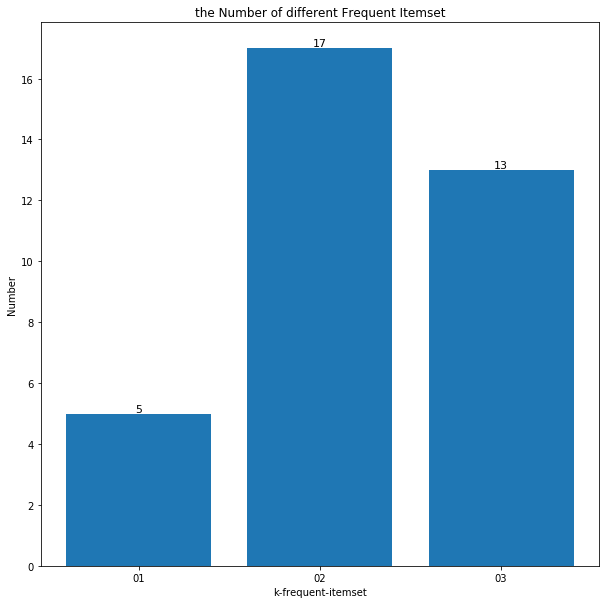

In [341]:
fig = plt.figure(figsize=(10,10)) # 建立一个10*10的画布
plot1 = fig.add_subplot(1,1,1)
X=sorted(list(set(X)))
plot1.set_title('the Number of different Frequent Itemset')
plot1.set_ylabel('Number')
plot1.set_xlabel('k-frequent-itemset')
plt.bar(x=X,height=Y)

for a,b in zip(X,Y):  
    plt.text(a, b, '%.0f' % b, ha='center', va= 'bottom',fontsize=11) 

上图为，不同项频繁项集对应的个数，比如1项频繁项集有5个，2项频繁项集有17个，3项频繁项集有13个

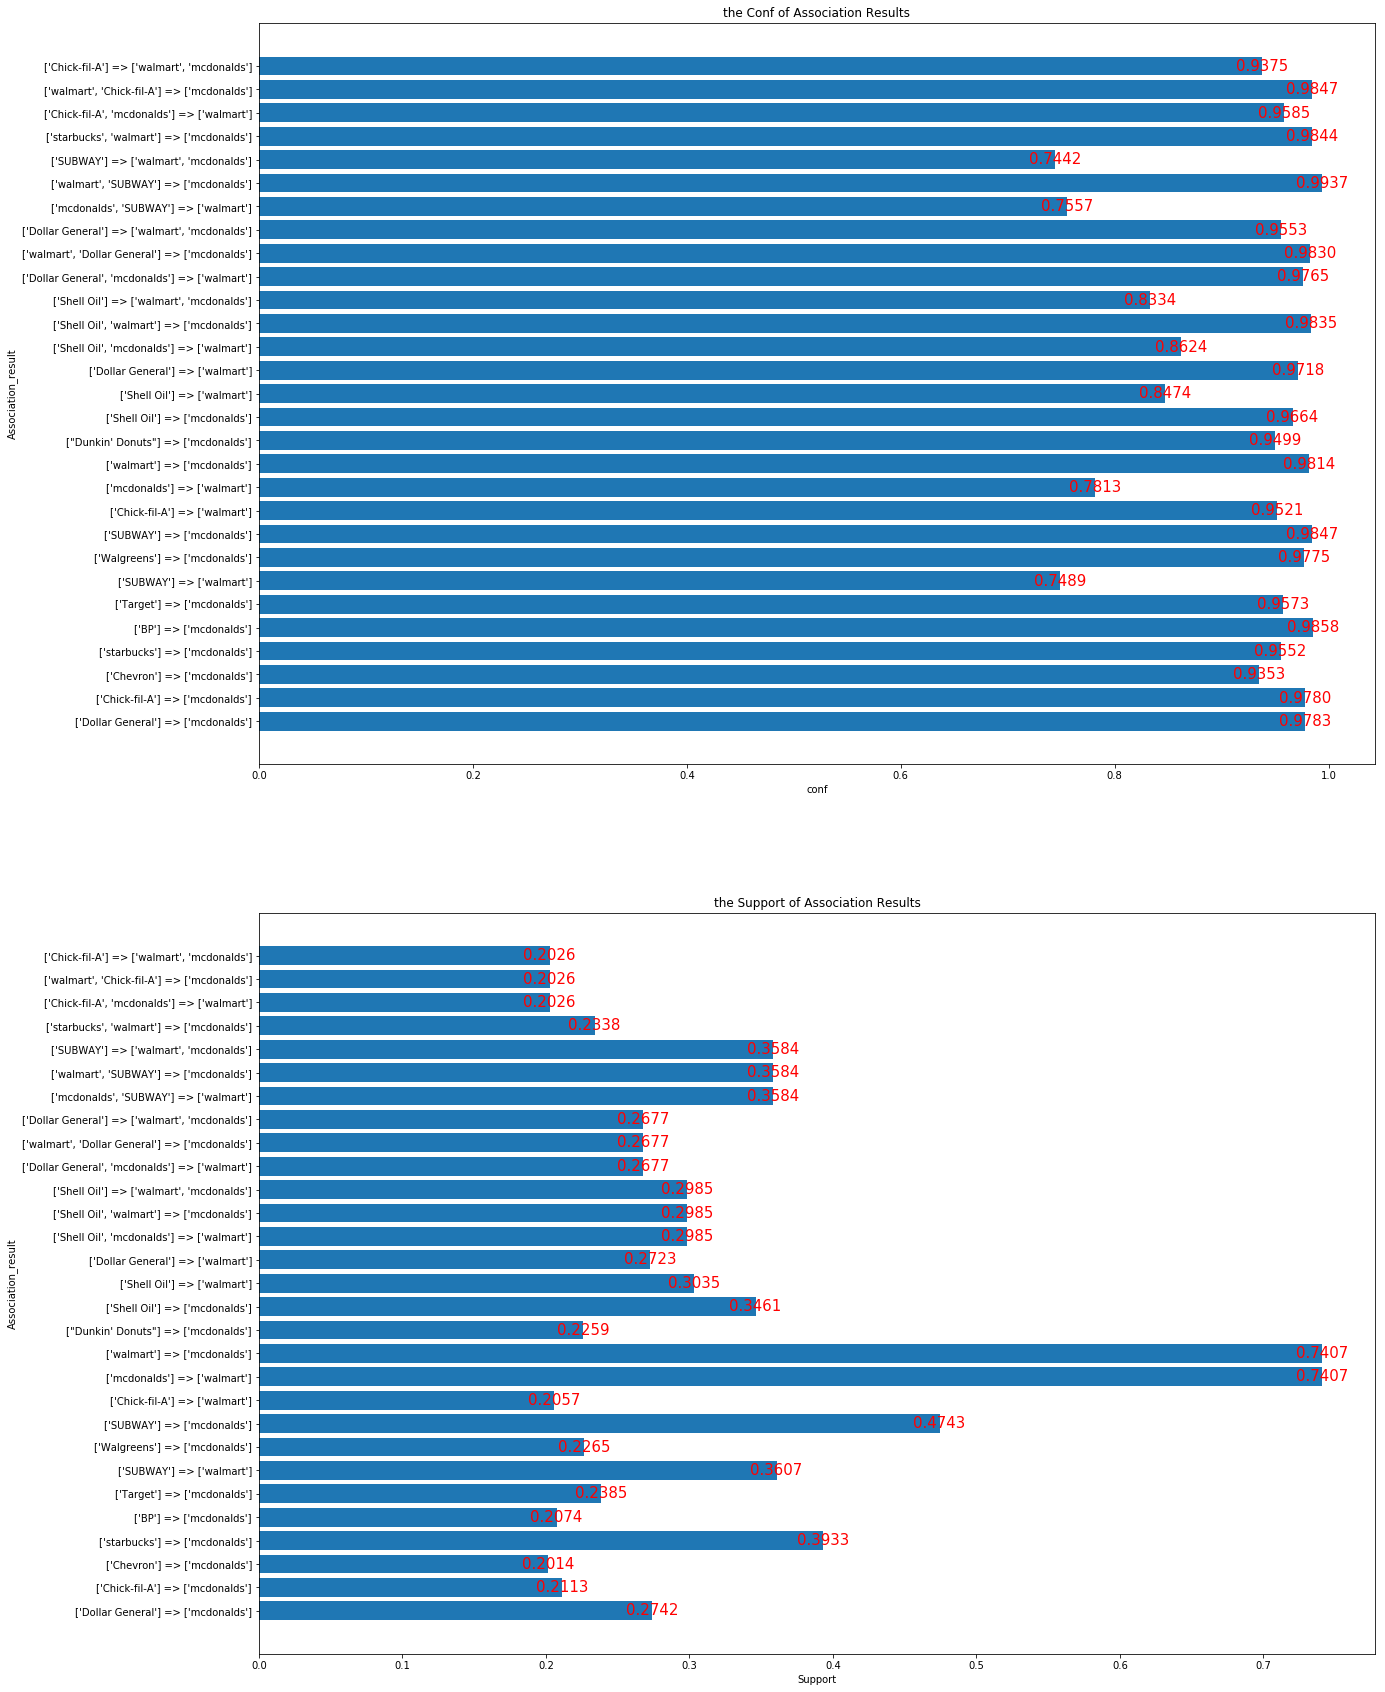

In [422]:
fig = plt.figure(figsize=(20,30)) # 建立一个20*30的画布
plot1 = fig.add_subplot(2,1,1)

plot1.set_title('the Conf of Association Results')
plot1.set_ylabel('Association_result')
plot1.set_xlabel('conf')
r = []
l = len(Association_result)
for i in range(l):
    s=str(list(Association_result['A'][i]))+' => '+str(list(Association_result['B'][i]))
    r.append(s)
c = [conf for conf in Association_result['Conf']]
plt.barh(r,c)
for a,b in zip(c,r):  
    plt.text(a, b, '%.4f' % a, ha='center', va= 'center',color='r',fontsize=15) 
    
plot2 = fig.add_subplot(2,1,2)

plot2.set_title('the Support of Association Results')
plot2.set_ylabel('Association_result')
plot2.set_xlabel('Support')
r = []
l = len(Association_result)
for i in range(l):
    s=str(list(Association_result['A'][i]))+' => '+str(list(Association_result['B'][i]))
    r.append(s)
c = [conf for conf in Association_result['Support']]
plt.barh(r,c)
for a,b in zip(c,r):  
    plt.text(a, b, '%.4f' % a, ha='center', va= 'center',color='r',fontsize=15) 

上图显示出挖掘出的关联规则对应的置信度和支持度


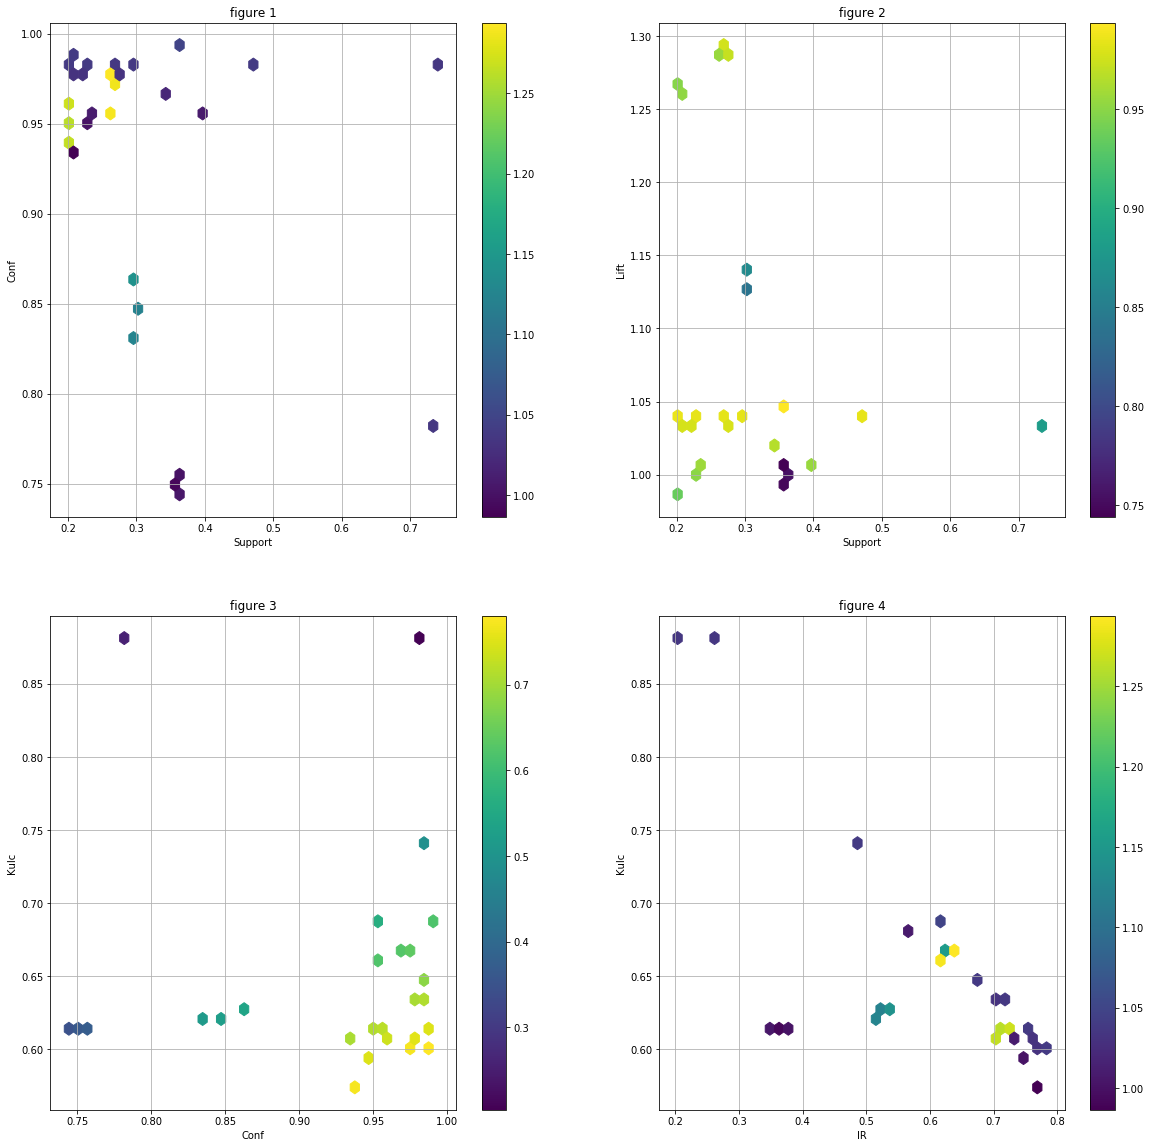

In [423]:
fig = plt.figure(figsize=(20,20)) # 建立一个10*10的画布
plot1 = fig.add_subplot(2,2,1)
result.plot(kind='hexbin',x='Support', y='Conf',ax=plot1,C='Lift',colormap='viridis',gridsize=40,grid=True,title='figure 1')

plot2 = fig.add_subplot(2,2,2)
result.plot(kind='hexbin',x='Support', y='Lift',ax=plot2,C='Conf',colormap='viridis',gridsize=40,grid=True,title='figure 2')

plot3 = fig.add_subplot(2,2,3)
result.plot(kind='hexbin',x='Conf', y='Kulc',ax=plot3,C='IR',colormap='viridis',gridsize=40,grid=True,title='figure 3')

plot4 = fig.add_subplot(2,2,4)
result.plot(kind='hexbin',x='IR', y='Kulc',ax=plot4,C='Lift',colormap='viridis',gridsize=40,grid=True,title='figure 4')

+ figure 1:置信度较高的点，支持度较低，且提升度反应为没有显著相关性
+ figure 2:提升度较高的点，支持度较低，置信度大多较高
+ figure 3:有两个点具有较高的关联度，并且不平衡度较低，置信度略有不同
+ figure 4:有两个点具有较高的关联度，并且不平衡度较低，提升度表现为没有显著相关性